# LabelPlacement 

In [149]:
import pysat.solvers
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from collections import defaultdict

## Parser 

In [114]:
class Parser:
    def __init__(self, 
                 file_path : str, 
                 area_w : int = 500, 
                 area_h : int = 500):
        
        self.area_w, self.area_h = area_w, area_h
        self.points = []
        counter = 1
        
        with open(file_path) as f:
            for line in f:
                (x, y), (w, h), placement_list = self.parse_input(line)

                point = {}
                point["center"] = (x, y)
                point["placements"] = {}
                for placement in placement_list:
                    pl_x, pl_y = placement
                    point["placements"][counter] = [x - pl_x, y - pl_y, w, h]
                    if not self.in_area(point["placements"][counter]):
                        continue
                    counter += 1
                self.points.append(point)
    
    def parse_input(self, line):
        center, size, placements = line.strip().split("\t")
        x, y = center.split(",")
        w, h = size.split(",")

        placement_list = []
        for placement in placements.split(" "):
            pl_x, pl_y = placement.split(",")
            placement_list.append((int(pl_x), int(pl_y)))

        return (int(x), int(y)), (int(w), int(h)), placement_list
    
    
    def in_area(self, placement):
        (x, y, w, h) = placement
        if (x >= 0 and x <= self.area_w) and \
           (y >= 0 and y <= self.area_h):
            return True
        else:
            return False

### Solver 

In [287]:
class Solver:
    def __init__(self):
        self.solver = pysat.solvers.Solver(name="mc")
    
    
    def get_placements(self, points: list):
        placements = {}
        for point in points:
            for key, value in point["placements"].items():
                placements[key] = value
        return placements
    
    
    def get_intersections(self, placements):
        def is_intersect(a, b):
            def is_contains(point, placement):
                x, y = point
                px, py, w, h = placement

                if (px <= x and px + w >= x) and \
                   (py <= y and py + h >= y):
                        return True
                return False

            px, py, w, h = a
            points = [[px, py], [px+w, py], 
                      [px, py+h], [px+w, py+w]]

            for point in points:
                if is_contains(point, b):
                    return True
            return False
        
        intersections = defaultdict(set)
        
        for id1 in placements.keys():
            for id2 in placements.keys():
                if id1 == id2:
                    continue
                
                if is_intersect(placements[id1], placements[id2]):
                    intersections[id1].add(id2)
                    
        return intersections
    
    
    def add_clause(self, points, placements, intersections):
        for point in points:
            self.solver.add_clause(list(point["placements"].keys()))
        
        for id_, placement in placements.items():
            for intersect in intersections[id_]:
                self.solver.add_clause([-id_, -intersect])
    
    
    def solve(self, points : list):
        self.placements = self.get_placements(points)
        intersections = self.get_intersections(placements)
        
        self.add_clause(points, placements, intersections)
        
        true_placements = []
        if self.solver.solve():
            for placement in self.solver.get_model():
                if placement > 0:
                    true_placements.append(placement)
            return true_placements
        else:
            return None

## Example 

In [297]:
def draw_placements(points, true_placements, placements):
    fig, ax = plt.subplots(figsize=(10,10))

    for point in points:
        ax.scatter(point["center"][0], point["center"][1])

    for true_pl in true_placements:
        plac = placements[true_pl]
        ax.add_patch(Rectangle(xy=(plac[0] ,plac[1]), 
                               width=plac[2], height=plac[3]))

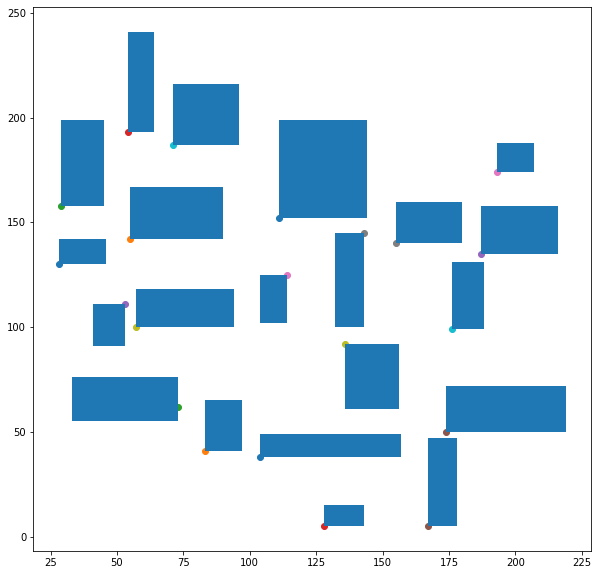

In [300]:
parser = Parser(file_path="in/test.txt")
solver = Solver()
true_placements = solver.solve(parser.points)
draw_placements(parser.points, frames, solver.placements)
plt.savefig("out/label_placement.png")